# Projet : inpainting

Ariana CARNIELLI &mdash; 3525837

In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import utils
import utils_preambule as ut_p

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib notebook

## 1. Préambule : régression linéaire, régression ridge et LASSO

Dans cette partie, on compare les régressions linéaire, ridge et LASSO sur la base de données USPS de classification de chiffres manuscrits. Pour cela, on utilise les regressions linéaires `LinearRegression`, `Ridge` et `Lasso` implémentées sur `sklearn.linear_model`. On rappelle que les régressions linéaire et de ridge ont été implémentées dans le TME 3, mais on a choisi d'utiliser les classes déjà implémentées par `sklearn` car elles contiennent des optimisations qui n'ont pas été implémentées lors de ce TME et tournent ainsi plus vite.

Les classes `LinearRegression`, `Ridge` et `Lasso` permettent, à l'aide de l'argument `normalize` de leurs constructeurs, de normaliser les données d'entrée en soustrayant la moyenne et divisant par l'écart-type de chaque colonne du dataset d'apprentissage. On a choisi de le faire, en mettant `normalize` à `True`, dans tous les tests présentés dans cette partie.

Comme il s'agit d'un problème de classification multi-classes, il faut aussi utiliser les méthodes de classification multi-classes. Comme indiqué ci-dessous (voir Section 1.1), on a rencontré des problèmes avec le `OneVsOneClassifier` du module `sklearn.multiclass` et, ainsi, on a utilisé les classes `OvA` et `OvO` codées au TME 4, compris dans le fichiers `utils_preambule.py`.

On commence par charger la base de données USPS.

In [2]:
trainX, trainY = ut_p.load_usps("USPS_train.txt")    
testX, testY = ut_p.load_usps("USPS_test.txt")

Les régressions rigde et LASSO dépendent chacune d'un paramètre $\alpha$, qui représente le poids donné à la norme 1 ou 2 dans la fonction à minimiser. Afin de trouver la meilleure valeur de $\alpha$ dans chacun des cas, on utilise l'optimisation d'hyper-paramètres `GridSearchCV` de `sklearn.model_selection` (comme dans le TME 4). Pour cela, il a fallu adapter les classes `OvA` et `OvO`, en codant les méthodes `get_params` et `set_params`, afin qu'elles deviennent compatibles avec `GridSearchCV`.

On a quatre valeurs de $\alpha$ à estimer :

- Une valeur pour `Ridge` avec le `OvA`
- Une valeur pour `Ridge` avec le `OvO`
- Une valeur pour `Lasso` avec le `OvA`
- Une valeur pour `Lasso` avec le `OvO`

On commence alors par chercher ces meilleurs valeurs de $\alpha$ à l'aide de la base d'apprentissage. Comme les valeurs de $\alpha$ optimales trouvées sont d'ordres de grandeur différentes, on a choisi des grilles de recherche différentes à chaque fois (en trouvant d'abord l'ordre de grandeur de chaque $\alpha$ empiriquement avec des tests).

In [4]:
bestParams = {}
grids = {(Ridge, ut_p.OvA): np.logspace(-2, -1, 10),\
         (Ridge, ut_p.OvO): np.logspace(-1,  0, 10),\
         (Lasso, ut_p.OvA): np.logspace(-6.5, -5.5, 10),\
         (Lasso, ut_p.OvO): np.logspace(-4.1, -3.1, 10)}
for est in [Ridge, Lasso]:
    for cla in [ut_p.OvA, ut_p.OvO]:
        bestParams[(est, cla)] = GridSearchCV(cla(est, 10, normalize = True),\
                                              {'alpha': grids[(est, cla)]})
        bestParams[(est, cla)].fit(trainX, trainY)
        print("Meilleur alpha pour ({}, {}): {}".format(est.__name__, cla.__name__,\
                                                        bestParams[(est, cla)].best_params_['alpha']))


Meilleur alpha pour (Ridge, OvA): 0.0774263682681127
Meilleur alpha pour (Ridge, OvO): 0.1291549665014884
Meilleur alpha pour (Lasso, OvA): 8.799225435691074e-07
Meilleur alpha pour (Lasso, OvO): 0.00010259143654700108


Une fois les meilleurs $\alpha$ calculés, on implémente les classificateurs multi-classes.

In [12]:
classifiers = {}
for est in [LinearRegression, Ridge, Lasso]:
    for cla in [ut_p.OvA, ut_p.OvO]:
        if (est, cla) in bestParams:
            classifiers[(est, cla)] = cla(est, 10, normalize = True,\
                                          alpha = bestParams[(est, cla)].best_params_['alpha'])
        else:
            classifiers[(est, cla)] = cla(est, 10, normalize = True)
        classifiers[(est, cla)].fit(trainX, trainY)

Dans un premier temps, on regarde les résultats de chaque classification en apprentissage et en test.

In [13]:
print("+--------------------+-----------+-----------+")
print("| Train              | OvA       | OvO       |")
print("+--------------------+-----------+-----------+")
for est in [LinearRegression, Ridge, Lasso]:
    print("| {:18s} | ".format(est.__name__), end="")
    for cla in [ut_p.OvA, ut_p.OvO]:
        print("   {:6.4f} | ".format(classifiers[(est, cla)].score(trainX, trainY)), end="")
    print("")
print("+--------------------+-----------+-----------+")

print("+--------------------+-----------+-----------+")
print("| Test               | OvA       | OvO       |")
print("+--------------------+-----------+-----------+")
for est in [LinearRegression, Ridge, Lasso]:
    print("| {:18s} | ".format(est.__name__), end="")
    for cla in [ut_p.OvA, ut_p.OvO]:
        print("   {:6.4f} | ".format(classifiers[(est, cla)].score(testX, testY)), end="")
    print("")
print("+--------------------+-----------+-----------+")

+--------------------+-----------+-----------+
| Train              | OvA       | OvO       |
+--------------------+-----------+-----------+
| LinearRegression   |    0.9240 |    0.9841 | 
| Ridge              |    0.9209 |    0.9770 | 
| Lasso              |    0.9240 |    0.9763 | 
+--------------------+-----------+-----------+
+--------------------+-----------+-----------+
| Test               | OvA       | OvO       |
+--------------------+-----------+-----------+
| LinearRegression   |    0.8695 |    0.9118 | 
| Ridge              |    0.8764 |    0.9258 | 
| Lasso              |    0.8710 |    0.9203 | 
+--------------------+-----------+-----------+


Avec les bons taux de classification en apprentissage et en test des classifieurs précédents, on procède à la comparaison de leurs vecteurs `w`.

<IPython.core.display.Javascript object>


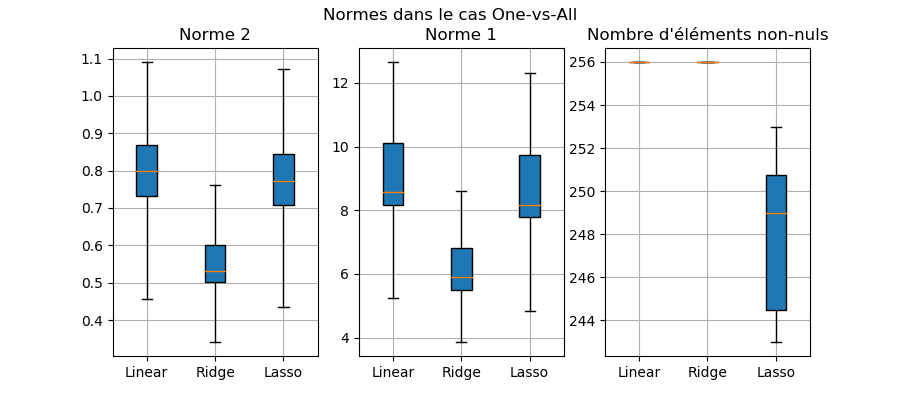

<IPython.core.display.Javascript object>


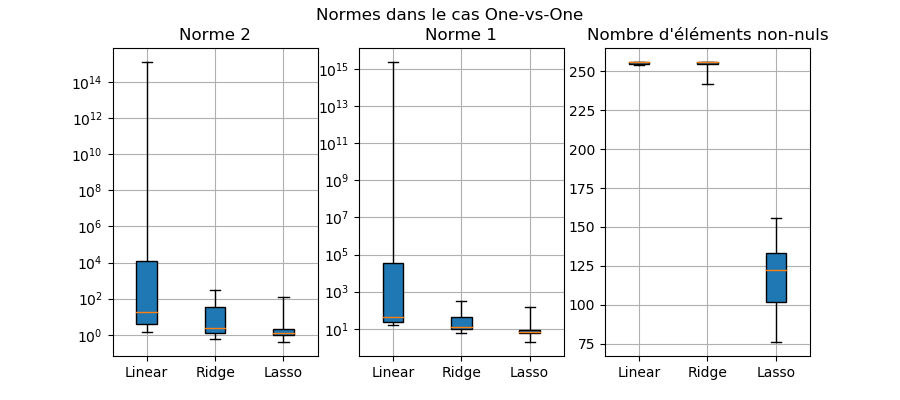

In [15]:
# Dictionnaires qui contiendront les normes 2 et 1 et la quantité d'éléments non-nuls de w.
wNorm2 = {}
wNorm1 = {}
wNonNul = {}

# Remplissage des dictionnaires
# Comme ut_p.OvA et ut_p.OvO stockent les classifieurs internes de façons différentes (tableau numpy pour le 
# premier, dictionnaire pour le deuxième), les deux cas sont traités de façon séparée
for est in [LinearRegression, Ridge, Lasso]:
    cl = classifiers[(est, ut_p.OvA)]
    wNorm2[(est, ut_p.OvA)] = np.array([np.linalg.norm(c.coef_, 2) for c in cl.classifiers])
    wNorm1[(est, ut_p.OvA)] = np.array([np.linalg.norm(c.coef_, 1) for c in cl.classifiers])
    wNonNul[(est, ut_p.OvA)] = np.array([np.linalg.norm(c.coef_, 0) for c in cl.classifiers])
    
    cl = classifiers[(est, ut_p.OvO)]
    wNorm2[(est, ut_p.OvO)] = np.array([np.linalg.norm(c.coef_, 2) for c in cl.classifiers.values()])
    wNorm1[(est, ut_p.OvO)] = np.array([np.linalg.norm(c.coef_, 1) for c in cl.classifiers.values()])
    wNonNul[(est, ut_p.OvO)] = np.array([np.linalg.norm(c.coef_, 0) for c in cl.classifiers.values()])

# Affichage pour OvA
fig, ax = plt.subplots(1, 3, figsize=(9, 4))
for i, w in enumerate([wNorm2, wNorm1, wNonNul]):
    ax[i].boxplot([w[(m, ut_p.OvA)] for m in [LinearRegression, Ridge, Lasso]], whis='range', patch_artist = True)
    ax[i].set_xticklabels(["Linear", "Ridge", "Lasso"])
    ax[i].grid(True)
    ax[i].set_axisbelow(True)
fig.suptitle("Normes dans le cas One-vs-All")
ax[0].set_title("Norme 2")
ax[1].set_title("Norme 1")
ax[2].set_title("Nombre d'éléments non-nuls")
    
# Affichage pour OvO
fig, ax = plt.subplots(1, 3, figsize=(9, 4))
for i, w in enumerate([wNorm2, wNorm1, wNonNul]):
    ax[i].boxplot([w[(m, ut_p.OvO)] for m in [LinearRegression, Ridge, Lasso]], whis='range', patch_artist = True)
    ax[i].set_xticklabels(["Linear", "Ridge", "Lasso"])
    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    if i < 2:
        ax[i].set_yscale("log")
fig.suptitle("Normes dans le cas One-vs-One")
ax[0].set_title("Norme 2")
ax[1].set_title("Norme 1")
ax[2].set_title("Nombre d'éléments non-nuls");

Dans le cas One-vs-One, on dispose de 10*9/2 = 45 classifieurs (et donc 45 vecteurs `w` pour chaque type de régression) et, dans le cas One-vs-All, de 10 classifieurs (avec, similairement, 10 vecteurs `w` pour chaque type de régression). On présente dans les figures ci-dessus les caractéristiques statisques des normes 2 et 1 et du nombre d'éléments non-nuls de ces `w` : valeurs maximaux et minimaux, quartiles et médiane.

Plusieurs caractéristiques intéressantes ressortent des figures ci-dessus. Tout d'abord, on remarque que, dans tous les cas, les régressions `Ridge` et `Lasso` permettent de réduire les normes 2 et 1 de `w` par rapport au cas du `LinearRegression`, ce qui était attendu car les termes de régularisation introduits ont justement pour objectif de réduire ces normes. La réduction observée pour `Lasso` dans le cas One-vs-All est très petite car la valeur de $\alpha$ trouvée par optimisation par `GridSearchCV` est de l'ordre de `1e-6`, et ainsi le résultat de `Lasso` est très proche de `LinearRegression` puisque les deux fonctions à optimiser sont très proches dans ce cas.

Le cas One-vs-One permet aussi de montrer l'intérêt de ces régularisations : alors que les normes 2 et 1 de `w` est énorme pour `LinearRegression`, de l'ordre de `1e15`, les deux régularisations permettent de les réduire de plusieurs ordres de grandeur. Pour une meilleure visualisation, les graphiques correspondants sont en échelle logarithmique.

L'intérêt de `Lasso` est démontré dans les graphiques du nombre d'éléments non-nuls de `w`. Alors que `LinearRegression` et `Ridge` ont tous leurs 256 éléments non-nuls ou presque, `Lasso` a plus d'éléments nuls. Cela est déjà le cas dans le One-vs-All, malgré la très petite valeur de $\alpha$ dans ce cas, et encore plus visible dans le cas One-vs-One, dans lequel $\alpha$ est plus grand. Ainsi, on voit clairement que la régularisation faite par `Lasso` permet en effet non seulement de réduire la norme de `w`, comme `Ridge`, mais aussi d'augmenter la quantité d'éléments nuls de `w`. Cela veut dire que moins de *features* (dans ce cas, pixels) sont pris en considération pour la classification.

### 1.1. Comparaison entre les classificateurs multi-classes de `sklearn.multiclass` et du TME 4

Comme indiqué avant, on a trouvé des soucis dans le fonctionnement de la classe `OneVsOneClassifier` de `sklearn.multiclass`. On re-fait ci-dessous les implémentations des classificateurs multi-classes qu'avant en utilisant les classificateurs de `sklearn.multiclass` à la place de ceux du TME4, en utilisant les valeurs de $\alpha$ trouvés précédemment.

In [9]:
classifiers = {}
for est in [LinearRegression, Ridge, Lasso]:
    for cla in [(ut_p.OvA, OneVsRestClassifier), (ut_p.OvO, OneVsOneClassifier)]:
        if (est, cla[0]) in bestParams:
            classifiers[(est, cla[1])] = cla[1](est(normalize = True,\
                                                    alpha = bestParams[(est, cla[0])].best_params_['alpha']))
        else:
            classifiers[(est, cla[1])] = cla[1](est(normalize = True))
        classifiers[(est, cla[1])].fit(trainX, trainY)

In [10]:
print("+--------------------+-----------+-----------+")
print("| Train              | OneVsRest | OneVsOne  |")
print("+--------------------+-----------+-----------+")
for est in [LinearRegression, Ridge, Lasso]:
    print("| {:18s} | ".format(est.__name__), end="")
    for cla in [OneVsRestClassifier, OneVsOneClassifier]:
        print("   {:6.4f} | ".format(classifiers[(est, cla)].score(trainX, trainY)), end="")
    print("")
print("+--------------------+-----------+-----------+")

print("+--------------------+-----------+-----------+")
print("| Test               | OneVsRest | OneVsOne  |")
print("+--------------------+-----------+-----------+")
for est in [LinearRegression, Ridge, Lasso]:
    print("| {:18s} | ".format(est.__name__), end="")
    for cla in [OneVsRestClassifier, OneVsOneClassifier]:
        print("   {:6.4f} | ".format(classifiers[(est, cla)].score(testX, testY)), end="")
    print("")
print("+--------------------+-----------+-----------+")

+--------------------+-----------+-----------+
| Train              | OneVsRest | OneVsOne  |
+--------------------+-----------+-----------+
| LinearRegression   |    0.9240 |    0.0979 | 
| Ridge              |    0.9209 |    0.2585 | 
| Lasso              |    0.9242 |    0.2665 | 
+--------------------+-----------+-----------+
+--------------------+-----------+-----------+
| Test               | OneVsRest | OneVsOne  |
+--------------------+-----------+-----------+
| LinearRegression   |    0.8695 |    0.0967 | 
| Ridge              |    0.8764 |    0.2481 | 
| Lasso              |    0.8714 |    0.2551 | 
+--------------------+-----------+-----------+


Comme observé dans les tableaux ci-dessus, les classificateurs multi-classes `OneVsRestClassifier` de `sklearn.multiclass` et `OvA` du TME 4 ont des résultats essentiellement identiques, en apprentissage et en test. Cependant, `OneVsOneClassifier` de `sklearn.multiclass` semble ne rien apprendre de la base de données, alors que `OvO` du TME 4 a de très bons résultats, même mieux que ceux de `OvA`. Après avoir analysé le code source de la classe `OneVsOneClassifier` à l'aide de la commande `OneVsOneClassifier??`, on n'est pas parvenu à expliquer ces mauvais résultats, et on a decidé alors de ne garder que les classificateurs codés au TME 4.

## 2. LASSO et Inpainting

## 2.1. Manipulation et bruitage d'images

Pour représenter des images, on a implémenté une classe `Image` qui stocke l'image et qui contient des méthodes permettant de la manipuler. La classe contient :

* Un constructeur qui peut prendre en argument un nom de fichier (`filename`) ou un tableau `numpy` contenant les données de l'image (`img_data`), ainsi qu'un argument booléen `hsv` qui détermine si l'image doit être représentée en HSV (`True`) ou RGB (`False`).
* Une méthode interne `_from_file(self, filename)` qui lit l'image depuis le fichier donné en argument au constructeur, convertissant ses entrées à l'intervalle $[-1, 1]$ et en HSV si nécessaire. On suppose toujours qu'il s'agira d'une image en couleurs à 3 canaux.
* Une méthode `show(self, color)` qui permet de l'afficher, avec un argument facultatif `color` qui permet de déterminer en quelle couleur seront affichés les pixels manquants (défault : noir)
* Une méthode `get_patch(self, i, j, h)` qui extrait le patch carré centré en `(i, j)` et de côté `h`.
* Une méthode `add_noise(self, p)` qui rajoute du bruit à toute l'image avec un pourcentage de bruit de `p`.
* Une méthode `add_noise_rect(self, p, i, j, height, width)` qui rajoute du bruit au rectangle centré en `(i, j)` et de côtés `height` et `width`.
* Une methode `delete_rect(self, i, j, height, width)` qui efface le rectangle centré en `(i, j)` et de côtés `height` et `width`.
* Une méthode `get_noisy_and_atoms(self, h, step)` qui construit deux dictionnaires, l'un avec les patchs avec au moins un pixel bruité et l'autre avec les patchs sans aucun pixel bruité. Les patchs sont de côté `h` et leurs centrés sont espacés de `step`.

À l'extérieur de la classe `Image`, on a implémenté les fonctions permettant de manipuler des patches :
* Une fonction auxiliaire `patch_to_vect(patch)` qui convertit un patch, tableau `numpy` à 3 dimensions, en un vecteur, tableau `numpy` à une dimension.
* Une fonction auxiliaire `vect_to_patch(vect)` qui convertit un vecteur, tableau `numpy` à une dimension, en un patch, tableau `numpy` à 3 dimensions.



On commence par tester les méthodes de base sur une image test. On a choisi une image de test assez connue des utilisateurs d'un certain système d'exploitation commercial très populaire au début des années 2000...

In [3]:
importlib.reload(utils)

<module 'utils' from 'D:\\Ariana\\Documentos\\Faculdade\\ML\\TMEs\\Projet\\utils.py'>

<IPython.core.display.Javascript object>


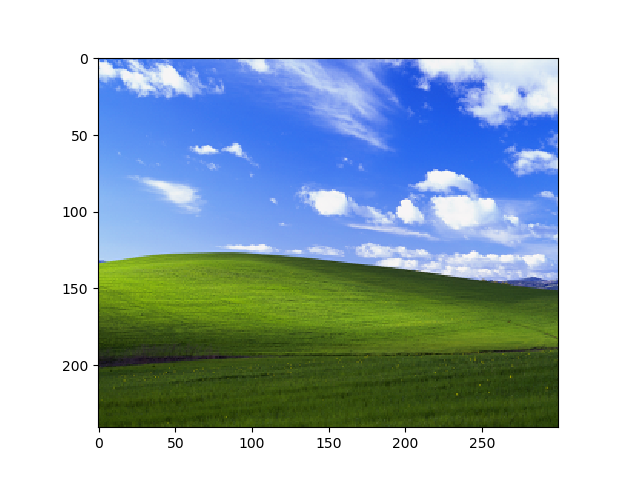

In [4]:
img_base = utils.Image("Images_Test/Bliss_Windows_XP.png", hsv = False)
plt.figure()
img_base.show()

Test du rajout de bruit (avec affichage en jaune) :

<IPython.core.display.Javascript object>


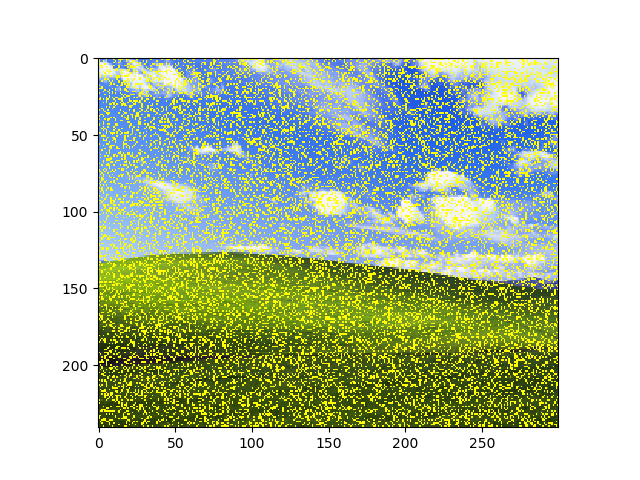

In [5]:
img = utils.Image(img_data = img_base.img, hsv = img_base.hsv)
img.add_noise(0.25)
plt.figure()
img.show(color=(1, 1, 0))

Test de rajout de bruit sur un rectangle (et affichage en violet):

<IPython.core.display.Javascript object>


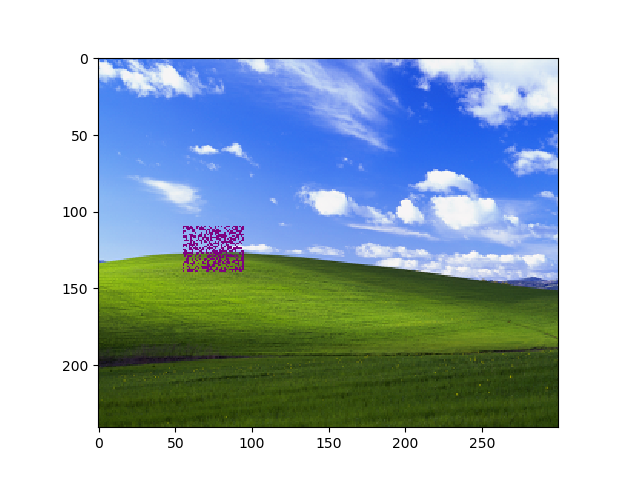

In [6]:
img = utils.Image(img_data = img_base.img, hsv = img_base.hsv)
img.add_noise_rect(0.5, 125, 75, 30, 40)
plt.figure()
img.show(color=(0.5, 0, 0.5))

Test de suppression d'un rectangle (avec l'affichage par défaut en noir) :

<IPython.core.display.Javascript object>


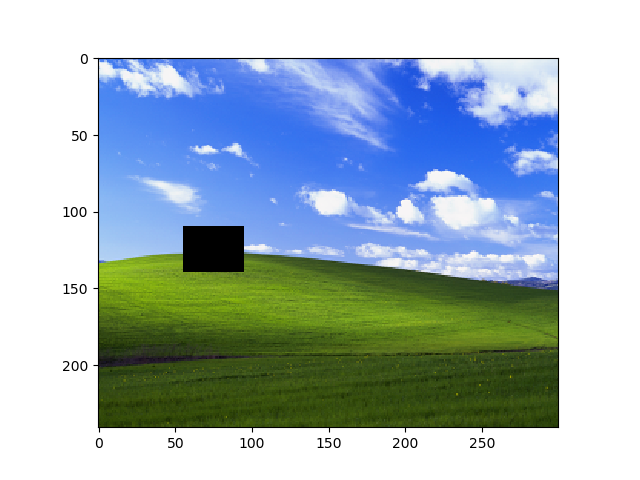

In [7]:
img = utils.Image(img_data = img_base.img, hsv = img_base.hsv)
img.delete_rect(125, 75, 30, 40)
plt.figure()
img.show()

Test d'extraction et affichage d'un patch:

<IPython.core.display.Javascript object>


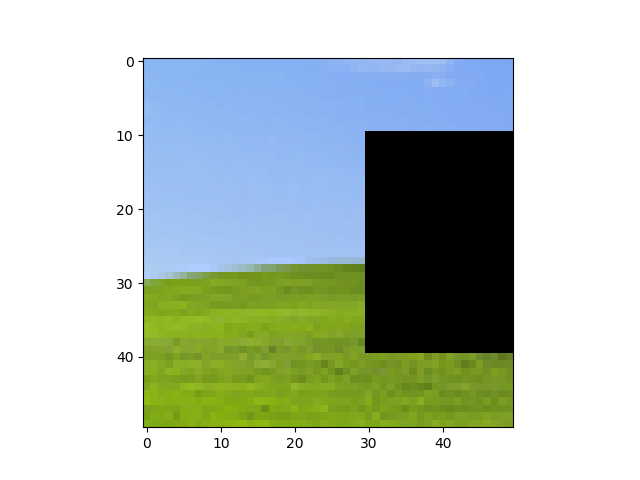

In [8]:
p = img.get_patch(125, 50, 50)
ip = utils.Image(img_data = p, hsv = img.hsv)
plt.figure()
ip.show()

## 2.2. Correction de patches individuels

On a implémenté la fonction `learn_w(noisy_patch, atoms, alpha)` qui permet de faire le *inpainting*. Elle prend en argument un patch avec bruit `noisy_patch`, un dictionnaire de patches sans bruit `atoms` et un nombre positif `alpha` et qui apprend la meilleure combinaision linéaire des éléments de `atoms` qui approche, au sens de l'algorithme LASSO avec paramètre de régularisation `alpha`, les pixels exprimés du patch `noisy_patch`. La fonction retourne le biais `w0`, le vecteur de poids `w` sous la forme d'un dictionnaire avec mêmes clés que `atoms` ainsi que le nouveau patch calculé à partir de `noisy_patch` en estimant les pixels bruités.

On commence par tester cette fonction sur une image sans bruit.

In [19]:
importlib.reload(utils)

<module 'utils' from 'D:\\Ariana\\Documentos\\Faculdade\\ML\\TMEs\\Projet\\utils.py'>

On a 858 atomes dans le dictionnaire et 0 patches bruités


<IPython.core.display.Javascript object>


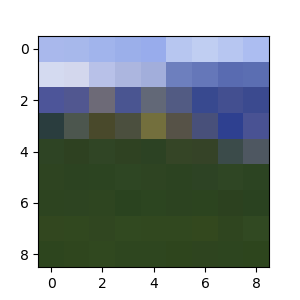

Intercept : -0.001775756896771008
Éléments non-nuls de w: {(139, 193): 0.001262081219988863, (139, 202): 0.0009389446585550753, (148, 265): 0.9929091149118136}
Norme 1 de w: 0.9951101407903575


In [53]:
h = 9

noisy, atoms = img_base.get_noisy_and_atoms(h, h)
# noisy doit être vide
print("On a {} atomes dans le dictionnaire et {} patches bruités".format(len(atoms), len(noisy)))

# On sélectionne un atome
a = atoms[(148, 265)]
ia = utils.Image(img_data = a, hsv = img_base.hsv)
plt.figure(figsize=(3, 3))
ia.show()

w0, w = utils.learn_w(a, atoms, alpha = 1e-3, predict = False)

# Affichage de w et w0 calculés
print("Intercept :", w0)
print("Éléments non-nuls de w:",{k:w[k] for k in w if not np.allclose(w[k], 0)})
print("Norme 1 de w:", abs(np.array(list(w.values()))).sum())

On remarque que, comme attendu, lorsque le patch à estimer est dans le dictionnaire d'atomes lui-même, le vecteur `w` est essentiellement concentré sur le patch lui-même : on a un coefficient très proche de 1 pour le patch à estimer et proche de 0 pour les autres patches présents et l'intercept. On remarque que le coefficient n'est pas exactement égal à 1 à cause de la régularisation de LASSO : le vecteur `w` trouvé a une norme 1 qui est en effet plus petite que 1. Cela dépend, évidemment, de la valeur de `alpha`, qui contrôle combien la norme 1 est prise en compte dans la minimisation : on remarque dans le tableau ci-dessus que, plus `alpha` est petit, plus le coefficient de l'atome lui-même se rapproche de 1 et plus la norme 1 du vecteur `w` trouvé se rapproche de 1.

In [51]:
a = atoms[(148, 265)]
alphas = np.logspace(-4, -1, 4)

print(" alpha | Coefficient de l'atome | Norme 1 de w ")
print("-------+------------------------+--------------")
for alpha in alphas:
    _, w = utils.learn_w(a, atoms, alpha = alpha, predict = False)
    print("{:6.0e} | {:22f} | {:12f}".format(alpha, w[(148, 265)], abs(np.array(list(w.values()))).sum()))

 alpha | Coefficient de l'atome | Norme 1 de w 
-------+------------------------+--------------
 1e-04 |               0.998853 |     0.999450
 1e-03 |               0.992909 |     0.995110
 1e-02 |               0.925494 |     0.950599
 1e-01 |               0.254456 |     0.505961


On teste maintenant la fonction `learn_w` sur un patch bruité. On rajoute un rectangle bruité dans l'image :

On a 838 atomes dans le dictionnaire et 20 patches bruités


<IPython.core.display.Javascript object>


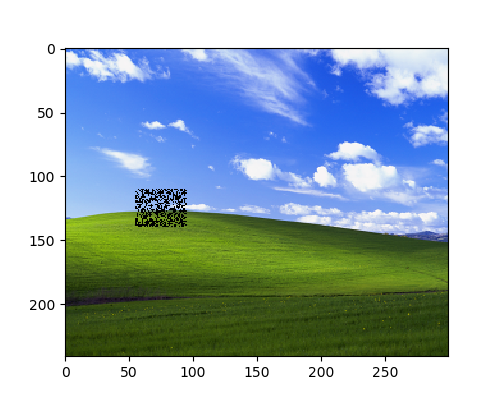

In [56]:
h = 9

# Création de l'image avec un rectangle bruité
img_noise = utils.Image(img_data = img_base.img, hsv = img_base.hsv)
img_noise.add_noise_rect(0.5, 125, 75, 30, 40)

# Création des dictionnaires de patches bruités et d'atomes, avec patches de taille h
noisy_noise, atoms_noise = img_noise.get_noisy_and_atoms(h, h)

print("On a {} atomes dans le dictionnaire et {} patches bruités".format(len(atoms_noise), len(noisy_noise)))

plt.figure(figsize=(5, 4))
img_noise.show()

On fait d'abord un appel à `learn_w` avec le dictionnaire précédent provenant de l'image sans bruit :

<IPython.core.display.Javascript object>


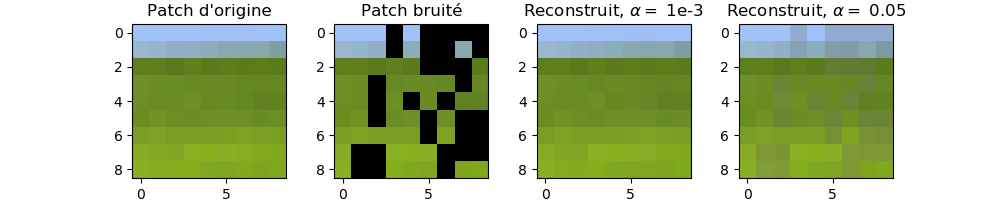

alpha : 0.001
Intercept : -0.0009818920581116802
Éléments non-nuls de w: {(130, 49): 0.008273525894634598, (130, 58): 0.9864237279632464}
Norme 1 de w: 0.994697253857881

alpha : 0.05
Intercept : -0.04091373944191405
Éléments non-nuls de w: {(130, 49): 0.2664589816469275, (130, 58): 0.47371274982558054}
Norme 1 de w: 0.740171731472508


In [65]:
fig, ax = plt.subplots(1, 4, figsize=(10, 2))

# On sélectionne un patch bruité
p = noisy_noise[(130, 58)]

# Affichage du patch d'origine
ip = utils.Image(img_data = atoms[(130, 58)], hsv = img_base.hsv)
ip.show(ax = ax[0])
ax[0].set_title("Patch d'origine")

# Affichage du patch bruité
ip = utils.Image(img_data = p, hsv = img_base.hsv)
ip.show(ax = ax[1])
ax[1].set_title("Patch bruité")

w0, w, new_p = utils.learn_w(p, atoms, alpha = 1e-3)

# Affichage du patch reconstruit avec alpha = 1e-3
ip = utils.Image(img_data = new_p, hsv = img_base.hsv)
ip.show(ax = ax[2])
ax[2].set_title(r"Reconstruit, $\alpha = $ 1e-3")

# Affichage de w et w0 calculés
print("alpha :", 1e-3)
print("Intercept :", w0)
print("Éléments non-nuls de w:",{k:w[k] for k in w if not np.allclose(w[k], 0)})
print("Norme 1 de w:", abs(np.array(list(w.values()))).sum())
print()

w0, w, new_p = utils.learn_w(p, atoms, alpha = 0.05)

# Affichage du patch reconstruit avec alpha = 0.05
ip = utils.Image(img_data = new_p, hsv = img_base.hsv)
ip.show(ax = ax[3])
ax[3].set_title(r"Reconstruit, $\alpha = $ 0.05")

# Affichage de w et w0 calculés
print("alpha :", 0.05)
print("Intercept :", w0)
print("Éléments non-nuls de w:",{k:w[k] for k in w if not np.allclose(w[k], 0)})
print("Norme 1 de w:", abs(np.array(list(w.values()))).sum())

Sans surprise, le vecteur `w` se concentre sur le patch correspondant dans l'image non-bruitée. Pour `alpha` petit, on ne prend quasiment que le patch d'origine et on obtient une très bonne qualité de reconstruction. Pour `alpha` plus grand, on cherche trop à minimiser la norme 1 de `w`, on prend alors en compte aussi un patch voisin, ce qui réduit la qualité visuelle de la reconstruiction.

On teste maintenant le cas plus réaliste où le dictionnaire d'apprentissage contient uniquement les patchs non-bruités de l'image bruitée.

<IPython.core.display.Javascript object>


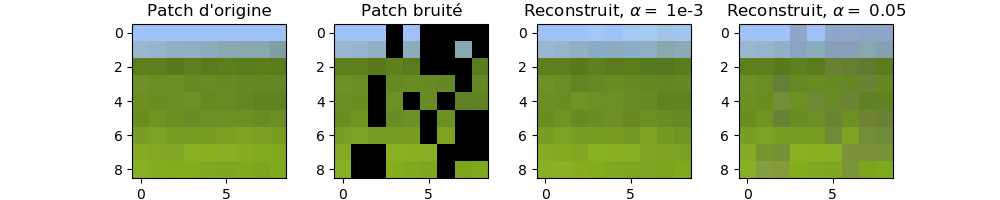

alpha : 0.001
Intercept : 0.08174707289013924
Éléments non-nuls de w: {(4, 211): -0.010726073271778023, (13, 220): -0.033040841337787744, (22, 22): -0.03467562105830831, (85, 148): 0.015507789950832379, (94, 193): -0.01475954705736641, (94, 202): 0.006405198743596819, (121, 103): 0.04839069936849576, (130, 13): 0.004301476199081647, (130, 22): 0.006321594989045395, (130, 40): -0.03494323058552807, (130, 49): 0.7623452360156031, (130, 103): 0.0791136478697523, (130, 121): -0.04128085181568264, (130, 166): 0.014119839931145217, (130, 283): 0.012132088135103586, (139, 283): 0.03350376370799311, (148, 247): 0.18894466517363118, (148, 265): 0.0404531730929262, (148, 274): 0.011243387075465301, (148, 292): -0.012600270599967236, (157, 157): 0.009283498610474446, (157, 166): 0.05243574157918855, (193, 103): 0.08513034792981922}
Norme 1 de w: 1.5516585840985724

alpha : 0.05
Intercept : -0.0670623374348487
Éléments non-nuls de w: {(130, 49): 0.7095825692763015}
Norme 1 de w: 0.7095825692763015

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(10, 2))

# On sélectionne un patch bruité
p = noisy_noise[(130, 58)]

# Affichage du patch d'origine
ip = utils.Image(img_data = atoms[(130, 58)], hsv = img_base.hsv)
ip.show(ax = ax[0])
ax[0].set_title("Patch d'origine")

# Affichage du patch bruité
ip = utils.Image(img_data = p, hsv = img_base.hsv)
ip.show(ax = ax[1])
ax[1].set_title("Patch bruité")

w0, w, new_p = utils.learn_w(p, atoms_noise, alpha = 1e-3)

# Affichage du patch reconstruit avec alpha = 1e-3
ip = utils.Image(img_data = new_p, hsv = img_base.hsv)
ip.show(ax = ax[2])
ax[2].set_title(r"Reconstruit, $\alpha = $ 1e-3")

# Affichage de w et w0 calculés
print("alpha :", 1e-3)
print("Intercept :", w0)
print("Éléments non-nuls de w:",{k:w[k] for k in w if not np.allclose(w[k], 0)})
print("Norme 1 de w:", abs(np.array(list(w.values()))).sum())
print()

w0, w, new_p = utils.learn_w(p, atoms_noise, alpha = 0.05)

# Affichage du patch reconstruit avec alpha = 0.05
ip = utils.Image(img_data = new_p, hsv = img_base.hsv)
ip.show(ax = ax[3])
ax[3].set_title(r"Reconstruit, $\alpha = $ 0.05")

# Affichage de w et w0 calculés
print("alpha :", 0.05)
print("Intercept :", w0)
print("Éléments non-nuls de w:",{k:w[k] for k in w if not np.allclose(w[k], 0)})
print("Norme 1 de w:", abs(np.array(list(w.values()))).sum())

On remarque que maintenant `w` ne peut pas être concentré sur le patch à estimer puisqu'il n'est pas sur le dictionnaire. Avec `alpha` petit, on retrouve un vecteur `w` qui prend en compte plusieurs patchs, avec une qualité visuelle de reconstruction plutôt bonne. En augmentant `alpha`, le critère de minimisation de la norme 1 gagne beaucoup d'importance et on a un seul patch qui est pris en compte dans la reconstruction, ce qui donne une qualité visuelle moins bonne.

On fait maintenant un test de reconstruction de tous les patchs bruités de l'image à partir du dictionnaire des patchs non-bruités de l'image bruitées et avec `alpha = 1e-3`.

In [75]:
# Nouvelle image qui contiendra la reconstruction
img_new = utils.Image(img_data = img_noise.img, hsv = img_noise.hsv)

for pos, p in noisy_noise.items():
    print("Reconstruction du patch bruité centré en ({}, {})".format(*pos))
    _, w, new_p = utils.learn_w(p, atoms_noise, 1e-3)
    print("    Le vecteur de poids a {:d} éléments non-nuls".format(int(np.linalg.norm(list(w.values()), 0))))
    img_new.get_patch(*pos, h)[:, :, :] = new_p

Reconstruction du patch bruité centré en (112, 58)
    Le vecteur de poids a 24 éléments non-nuls
Reconstruction du patch bruité centré en (112, 67)
    Le vecteur de poids a 18 éléments non-nuls
Reconstruction du patch bruité centré en (112, 76)
    Le vecteur de poids a 21 éléments non-nuls
Reconstruction du patch bruité centré en (112, 85)
    Le vecteur de poids a 19 éléments non-nuls
Reconstruction du patch bruité centré en (112, 94)
    Le vecteur de poids a 22 éléments non-nuls
Reconstruction du patch bruité centré en (121, 58)
    Le vecteur de poids a 22 éléments non-nuls
Reconstruction du patch bruité centré en (121, 67)
    Le vecteur de poids a 20 éléments non-nuls
Reconstruction du patch bruité centré en (121, 76)
    Le vecteur de poids a 19 éléments non-nuls
Reconstruction du patch bruité centré en (121, 85)
    Le vecteur de poids a 22 éléments non-nuls
Reconstruction du patch bruité centré en (121, 94)
    Le vecteur de poids a 22 éléments non-nuls
Reconstruction du pa

<IPython.core.display.Javascript object>


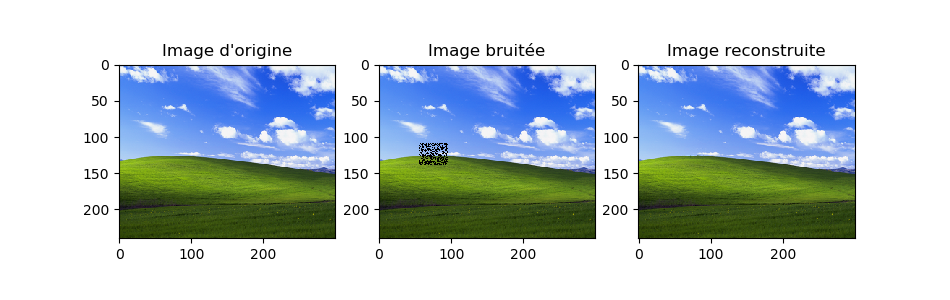

In [76]:
fig1, ax1 = plt.subplots(1, 3, figsize=(9.5, 3))

img_base.show(ax = ax1[0])
ax1[0].set_title("Image d'origine")

img_noise.show(ax = ax1[1])
ax1[1].set_title("Image bruitée")

img_new.show(ax = ax1[2])
ax1[2].set_title("Image reconstruite");

On remarque que l'on a alors une bonne qualité de reconstruction. Par contre, cette technique n'est applicable que si l'on a « peu » de bruit, dans le sens où tout patch avec du bruit doit contenir suffisamment de pixels sans bruit pour pouvoir réaliser un bon processus d'apprentissage. Ainsi, si on essaie d'appliquer cet algorithme dans le cas où toute une zone de l'image est manquante, il ne marchera pas car certains patches ne contiendront que des pixels bruités et aucun pixel pour l'apprentissage. Les techniques dans ce cas utilisent toujours l'idée de partir du bord de la zone bruitée : on reconstruit d'abord les pixels manquants proches du bord et ces mêmes pixels reconstruits sont utilisés pour reconstruire les prochaines parties de l'image. Ces techniques sont explorées dans la section suivante.

## 2.3. Correction d'une zone de l'image